# Battlestar Investigation 🚀

This notebook was created while participating in Apart Research’s Interpretability Hackathon, it incorporates significant threads of work conducted by Neel Nanda and Redwood Research. I would like to sincerely thank them for the wealth of resources they’ve provided in support of mechanistic interpretability research. Additionally, I would like to sincerely thank Apart Research for hosting such an enjoyable hackathon.

**Sources:**

* Kevin Wang, Alexandre Variengien, Arthur Conmy, Buck Shlegeris, Jacob Steinhardt: “Interpretability in the Wild: a Circuit for Indirect Object Identification in GPT-2 small”, 2022; arXiv:2211.00593.
* Neel Nanda: “SERI_MATS_IOI_Demo”, 2022; https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6
* Stanford University. “Mistral”, 2022. https://github.com/stanford-crfm/mistral
* Neel Nanda: “Easy Transformer Demo”, 2022: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/EasyTransformer_Demo.ipynb
* Redwood Research: “Easy Transformer”, 2022: https://github.com/redwoodresearch/Easy-Transformer
* Neel Nanda: “Easy Transformer”, 2022: https://github.com/neelnanda-io/Easy-Transformer 

## Imports

In [1]:
# Install Neel Nanda's Easy Transformer
import os
os.system("pip install git+https://github.com/neelnanda-io/Easy-Transformer.git")

0

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os


import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

In [3]:
# From: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/EasyTransformer_Demo.ipynb

from easy_transformer.utils import (
    gelu_new,
    to_numpy,
    get_corner,
    lm_cross_entropy_loss,
)  # Helper functions
from easy_transformer.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
from easy_transformer.experiments import (
    ExperimentMetric,
    AblationConfig,
    EasyAblation,
    EasyPatching,
    PatchingConfig,
)

# Setup

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_name = 'stanford-crfm/battlestar-gpt2-small-x49'
model = EasyTransformer.from_pretrained(model_name).to(device)

Loading model: stanford-crfm/battlestar-gpt2-small-x49


Downloading:   0%|          | 0.00/948 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


Moving model to device:  cuda
Finished loading pretrained model stanford-crfm/battlestar-gpt2-small-x49 into EasyTransformer!
Moving model to device:  cuda


In [6]:
torch.set_grad_enabled(False)

In [7]:
# From: https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6

#Plotting functions
# This is mostly a bunch of over-engineered mess to hack Plotly into producing 
# the pretty pictures I want, I recommend not reading too closely unless you 
# want Plotly hacking practice
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()
def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False), 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x=to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def scatter(x, y, **kwargs):
    px.scatter(x=to_numpy(x, flat=True), y=to_numpy(y, flat=True), **kwargs).show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Step 0: Verifying that the model can do IOI

In [8]:
# From https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6

print(model_name)
example_prompt = "While John and Mary were walking their dog, Mary handed the leash to" # @param
example_answer = " John" #@param
# Hacky function to map a text string to separate tokens as text
example_prompt_str_tokens = model.to_str_tokens(example_prompt, prepend_bos=True)
example_answer_str_tokens = model.to_str_tokens(example_answer)
print("Tokenized prompt:", example_prompt_str_tokens)
print("Tokenized answer:", example_answer_str_tokens)
prompt_length = len(example_prompt_str_tokens)
answer_length = len(example_answer_str_tokens)
example_logits = model(example_prompt+example_answer)
for index in range(prompt_length, prompt_length + answer_length):
    print("Logits for token:", example_answer_str_tokens[index - prompt_length])
    token_logits = example_logits[0, index-1]
    probs = torch.nn.functional.softmax(token_logits, dim=-1)
    values, indices = token_logits.sort(descending=True)
    for i in range(10):
        print(f"Top {i}th logit. Logit: {values[i].item():.6} Prob: {probs[indices[i]].item():.2%} Token: |{model.tokenizer.decode(indices[i])}|")

stanford-crfm/battlestar-gpt2-small-x49
Tokenized prompt: ['<|endoftext|>', 'While', ' John', ' and', ' Mary', ' were', ' walking', ' their', ' dog', ',', ' Mary', ' handed', ' the', ' leash', ' to']
Tokenized answer: [' John']
Logits for token:  John
Top 0th logit. Logit: 17.7579 Prob: 58.68% Token: | John|
Top 1th logit. Logit: 15.3223 Prob: 5.14% Token: | the|
Top 2th logit. Logit: 15.2834 Prob: 4.94% Token: | her|
Top 3th logit. Logit: 14.9084 Prob: 3.40% Token: | a|
Top 4th logit. Logit: 14.7718 Prob: 2.96% Token: | Mary|
Top 5th logit. Logit: 13.8227 Prob: 1.15% Token: | their|
Top 6th logit. Logit: 13.3766 Prob: 0.73% Token: | another|
Top 7th logit. Logit: 12.9261 Prob: 0.47% Token: | an|
Top 8th logit. Logit: 12.744 Prob: 0.39% Token: | his|
Top 9th logit. Logit: 12.7211 Prob: 0.38% Token: | him|


In [9]:
# From https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6

example_text = "While John and Mary were walking their dog, Mary handed the leash to"
#example_text_reverse = "While John and Mary were walking their dog, John handed the leash to"
john_index = model.tokenizer.encode(" John")[0]
mary_index = model.tokenizer.encode(" Mary")[0]
print(model_name)
def get_logit_diff(logits):
    # Takes in a batch x position x vocab tensor of logits, and returns the difference between the John and Mary logit
    return logits[0, -1, john_index] - logits[0, -1, mary_index]
example_logits = model(example_text) # Shape batch x position x vocab
example_logit_diff = get_logit_diff(example_logits)
#example_logits_reverse = model(example_text_reverse) # Shape batch x position x vocab
#example_logit_diff_reverse = get_logit_diff(example_logits_reverse)
print(f"Input text: {example_text}, John logit - Mary logit: {example_logit_diff.item()}")
#print(f"Input text: {example_text_reverse}, John logit - Mary logit: {example_logit_diff_reverse.item()}")

stanford-crfm/battlestar-gpt2-small-x49
Input text: While John and Mary were walking their dog, Mary handed the leash to, John logit - Mary logit: 2.986051559448242


# Step 1: Direct Logit Attribution

Run the model on the example text and cache all activations in example_cache, for future use

In [10]:
# From https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6

model.cfg.use_attn_result = True
example_cache = {}
model.cache_all(example_cache, remove_batch_dim=True)
_ = model(example_text)
model.reset_hooks()
model.cfg.use_attn_result = False
for act_name in example_cache:
    print(act_name, example_cache[act_name].shape)

hook_embed torch.Size([15, 768])
hook_pos_embed torch.Size([15, 768])
blocks.0.hook_resid_pre torch.Size([15, 768])
blocks.0.ln1.hook_scale torch.Size([15, 1])
blocks.0.ln1.hook_normalized torch.Size([15, 768])
blocks.0.attn.hook_q torch.Size([15, 12, 64])
blocks.0.attn.hook_k torch.Size([15, 12, 64])
blocks.0.attn.hook_v torch.Size([15, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([12, 15, 15])
blocks.0.attn.hook_attn torch.Size([12, 15, 15])
blocks.0.attn.hook_z torch.Size([15, 12, 64])
blocks.0.attn.hook_result torch.Size([15, 12, 768])
blocks.0.hook_attn_out torch.Size([15, 768])
blocks.0.hook_resid_mid torch.Size([15, 768])
blocks.0.ln2.hook_scale torch.Size([15, 1])
blocks.0.ln2.hook_normalized torch.Size([15, 768])
blocks.0.mlp.hook_pre torch.Size([15, 3072])
blocks.0.mlp.hook_post torch.Size([15, 3072])
blocks.0.hook_mlp_out torch.Size([15, 768])
blocks.0.hook_resid_post torch.Size([15, 768])
blocks.1.hook_resid_pre torch.Size([15, 768])
blocks.1.ln1.hook_scale torch.Size

In [11]:
# From https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6

# Set use attn result to True - this gives us a hook for the result of each head, 
# ie the d_model length vectors whose sum makes up attn_out and is added to the residual stream
print(model_name)
model.cfg.use_attn_result = True

logit_diff_direction = model.unembed.W_U[:, john_index] - model.unembed.W_U[:, mary_index]
# Take the scaling factor of the layernorm pre-unembed on the final token, so our logit attrs are on the same scale
final_layer_norm_scale = (example_cache['ln_final.hook_scale'][0, -1])
print("Final layer norm scaling factor:", final_layer_norm_scale.item())

direct_logit_attr = torch.zeros(model.cfg.n_layers, model.cfg.n_heads).to(device)
def calc_direct_logit_attr(result, hook):
    layer = int(hook.name.split('.')[1])
    final_token_result = result[0, -1]
    direct_logit_attr[layer] = (final_token_result @ (logit_diff_direction))/final_layer_norm_scale

model.run_with_hooks(example_text, fwd_hooks = [(lambda name:name.endswith('hook_result'), calc_direct_logit_attr)])

imshow(direct_logit_attr, xaxis='Head', yaxis='Layer', title='Direct Logit Attribution')

# Switch use_attn_result back off, since it consumes a lot of memory (Exercise: Why is this more expensive than eg calculating the value?)
model.cfg.use_attn_result = False

stanford-crfm/battlestar-gpt2-small-x49
Final layer norm scaling factor: 1.1641874313354492


# Step 2: Using Attention Patterns

In [12]:
# From: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/EasyTransformer_Demo.ipynb#scrollTo=E_3TPx6YH7eQ

def filter_hook_attn(name):
    split_name = name.split(".")
    return split_name[-1] == "hook_attn"

In [13]:
# From: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/EasyTransformer_Demo.ipynb#scrollTo=E_3TPx6YH7eQ

long_text = "A robot may not injure a human being or, through inaction, allow a human being to come to harm. \
A robot must obey the orders given it by human beings except where such orders would conflict with the First Law. \
A robot must protect its own existence as long as such protection does not conflict with the First or Second Law."

print("Long text:", long_text)
# We first cache attention patterns
attn_cache = {}


def cache_attn(attn, hook):
    attn_cache[hook.name] = attn


logits = model.run_with_hooks(long_text, fwd_hooks=[(filter_hook_attn, cache_attn)])

# We then go through the cache and find the average attention paid to previous tokens
prev_token_scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        attn = attn_cache[f"blocks.{layer}.attn.hook_attn"][0, head]
        prev_token_scores[layer, head] = attn.diag(-1).mean().item()

px.imshow(
    prev_token_scores,
    x=[f"Head {hi}" for hi in range(model.cfg.n_heads)],
    y=[f"Layer {i}" for i in range(model.cfg.n_layers)],
    title="Prev Token Scores",
    color_continuous_scale="Blues",
)

Long text: A robot may not injure a human being or, through inaction, allow a human being to come to harm. A robot must obey the orders given it by human beings except where such orders would conflict with the First Law. A robot must protect its own existence as long as such protection does not conflict with the First or Second Law.


# Step 3: Using Ablation Techniques

## a. Knocking out a single head

In [14]:
# From: https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6#scrollTo=Prn2z-G_YD3m

#model.reset_hooks()
def ablate_head_hook(value, hook, head_index):
    # Shape of value: batch x position x head_index x d_head
    value[:, :, head_index] = 0.
    return value

layer = 10
head_index = 7

example_prompt = "While John and Mary were walking their dog, Mary handed the leash to" # @param
example_answer = " John" #@param
# Hacky function to map a text string to separate tokens as text
example_prompt_str_tokens = model.to_str_tokens(example_prompt, prepend_bos=True)
example_answer_str_tokens = model.to_str_tokens(example_answer)
prompt_length = len(example_prompt_str_tokens)
answer_length = len(example_answer_str_tokens)

example_logits = model.run_with_hooks(example_prompt, fwd_hooks=[(f"blocks.{layer}.attn.hook_v", partial(ablate_head_hook, head_index=head_index))])

def get_logit_diff(logits):
    # Takes in a batch x position x vocab tensor of logits, and returns the difference between the John and Mary logit
    return logits[0, -1, john_index] - logits[0, -1, mary_index]

john_index = model.tokenizer.encode(" John")[0]
mary_index = model.tokenizer.encode(" Mary")[0]

for index in range(prompt_length, prompt_length + answer_length):
    token_logits = example_logits[0, index-1]
    probs = torch.nn.functional.softmax(token_logits, dim=-1)
    values, indices = token_logits.sort(descending=True)
    for i in range(2):
        print(f"Top {i}th logit. Logit: {values[i].item():.6} Prob: {probs[indices[i]].item():.2%} Token: |{model.tokenizer.decode(indices[i])}|")
    example_logit_diff = get_logit_diff(example_logits)
    print(f"Input text: {example_prompt}, John logit - Mary logit: {example_logit_diff.item()}")
#model.reset_hooks()

Top 0th logit. Logit: 17.1432 Prob: 41.74% Token: | John|
Top 1th logit. Logit: 15.9423 Prob: 12.56% Token: | Mary|
Input text: While John and Mary were walking their dog, Mary handed the leash to, John logit - Mary logit: 1.2008533477783203


## b. Ablating Each Head and Seeing Effect

In [15]:
# From: https://colab.research.google.com/drive/1mL4KlTG7Y8DmmyIlE26VjZ0mofdCYVW6#scrollTo=Prn2z-G_YD3m

def ablate_head_hook(value, hook, head_index):
    # Shape of value: batch x position x head_index x d_head
    value[:, :, head_index] = 0.
    return value

example_prompt = "While John and Mary were walking their dog, Mary handed the leash to" # @param
example_answer = " John" #@param
# Hacky function to map a text string to separate tokens as text
example_prompt_str_tokens = model.to_str_tokens(example_prompt, prepend_bos=True)
example_answer_str_tokens = model.to_str_tokens(example_answer)
prompt_length = len(example_prompt_str_tokens)
answer_length = len(example_answer_str_tokens)

head_ablation = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
logit_diff_history = []
for layer in tqdm.tqdm(range(model.cfg.n_layers)):
    for head_index in range(model.cfg.n_heads):
      example_logits = model.run_with_hooks(example_prompt, fwd_hooks=[(f"blocks.{layer}.attn.hook_v", partial(ablate_head_hook, head_index=head_index))])
      for index in range(prompt_length, prompt_length + answer_length):
        token_logits = example_logits[0, index-1]
        probs = torch.nn.functional.softmax(token_logits, dim=-1)
        values, indices = token_logits.sort(descending=True)
        example_logit_diff = get_logit_diff(example_logits)
        #print(f"Layer: {layer}, Head: {head_index}, Input text: {example_prompt}, John logit - Mary logit: {example_logit_diff.item()}")
        logit_diff_history.append(example_logit_diff.item())


  0%|          | 0/12 [00:00<?, ?it/s]

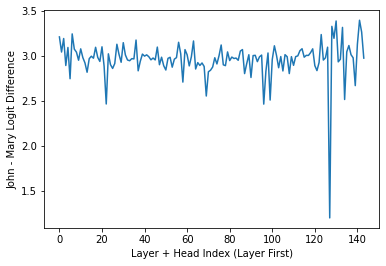

In [16]:
plt.plot(logit_diff_history)
plt.ylabel('John - Mary Logit Difference')
plt.xlabel('Layer + Head Index (Layer First)')
plt.show()